In [6]:
%%bash
exit 0


# you can use environment.yml file to set up the environment
mamba env create -f environment.yml
mamba activate cg-idps



In [7]:
import pandas as pd

# extracting experimental PRE for aSyn
# data taken from github:
# https://github.com/KULL-Centre/papers/tree/main/2021/CG-IDPs-Tesei-et-al/optimization/5_M1
M1 = pd.read_pickle('optimization/5_M1/o1_init_proteins.pkl')
# export PRE experimental data for aSyn
data = M1.loc["aSyn"].expPREs

# Create DataFrame with index as residue numbers
df = pd.DataFrame(data, index=range(1, 141))
df = df.loc[:, df.columns.get_level_values(0) != 'error']
df.columns = df.columns.get_level_values(1)
# Create index column first
df['resid'] = df.index
# Then rename other columns
df.columns = ['exp_24', 'exp_42', 'exp_62', 'exp_87', 'exp_103', 'resid']
# display(df)
# ['exp_24', 'exp_42', 'exp_62', 'exp_87', 'exp_103'] refer to the PRE label position

In [8]:
from DEERPREdict.PRE import PREpredict
import MDAnalysis
import pandas as pd

# path to pdb+xtc
pdb_path="md_2000ns_aSyn.gro"
dcd_path="shortened_traj_aSyn.xtc"

# PRE analysis of simulations using PREpredict
# label == residue with PRE probe
def evaluatePRE(label):
    u = MDAnalysis.Universe(pdb_path,dcd_path)
    PRE = PREpredict(u, label, log_file = 'file.log', temperature = 283, atom_selection = 'N', sigma_scaling = 1.0) # Cbeta=True
    PRE.run(output_prefix = 'calcPREs/res', load_file=False, tau_t = 1e-10, tau_c = 1.0*1e-09, r_2 = 10, wh = 700)

# numbers are positions of PRE probes (labels)
evaluatePRE(24)
evaluatePRE(42)
evaluatePRE(62)
evaluatePRE(87)
evaluatePRE(103)



,exp_24,exp_42,exp_62,exp_87,exp_103,resid,sim_24,sim_42,sim_62,sim_87,sim_103
1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,2,0.706978,0.735977,0.990571,0.463438,0.795607
3,0.890356,0.900316,0.903824,0.933050,1.067259,3,0.471502,0.878564,0.990870,0.559171,0.834681
4,0.870424,0.862499,0.970818,NaN,1.040277,4,0.736020,0.934926,0.989911,0.543675,0.865018
5,0.807188,0.778961,0.918528,0.954141,0.959283,5,0.797526,0.916668,0.982107,0.743324,0.825093
...,...,...,...,...,...,...,...,...,...,...,...
136,0.996978,0.931603,0.946582,0.977096,1.017958,136,0.713376,0.291430,0.743055,0.916048,0.966466
137,1.006794,0.782643,0.885704,0.898582,0.986754,137,0.847018,0.218877,0.710460,0.902510,0.947324
138,NaN,NaN,NaN,NaN,NaN,138,NaN,NaN,NaN,NaN,NaN
139,NaN,NaN,NaN,NaN,NaN,139,0.871310,0.338616,0.254888,0.963229,0.948892


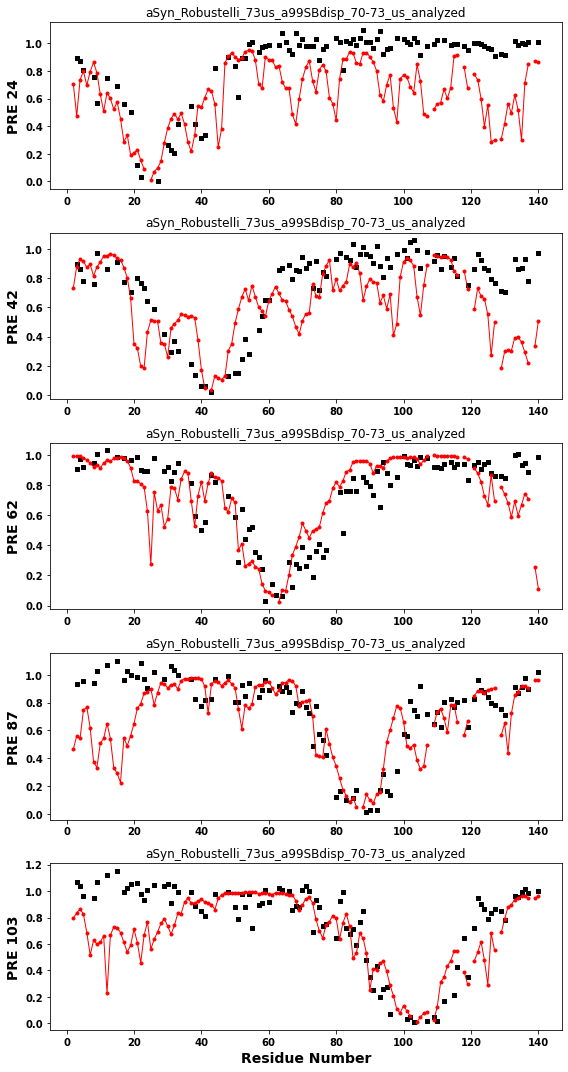

In [9]:


### PRE from simulations calcPREs dir to dataframe
dfs = {}
for label in [24, 42, 62, 87, 103]:
   filename = f'calcPREs/res-{label}.dat'
   dfs[label] = pd.read_csv(filename, delim_whitespace=True, skiprows=1, 
                           names=['residue', 'i_ratio', 'gamma_2'])

for label in [24, 42, 62, 87, 103]:
   dfs[label]['residue'] = dfs[label]['residue'].astype(int)
   dfs[label] = dfs[label].rename(columns={'residue': 'resid'})
   df.loc[df['resid'].isin(dfs[label]['resid']), f'sim_{label}'] = dfs[label].set_index('resid')['i_ratio']



### PLOTTING PRE experimental vs simulations
display(df)

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10, 'font.weight': 'bold'})

title='aSyn_Robustelli_73us_a99SBdisp_70-73_us_analyzed'

fig, axs = plt.subplots(5, 1, figsize=(8, 15))

for i, label in enumerate([24, 42, 62, 87, 103]):
   axs[i].scatter(df['resid'], df[f'exp_{label}'], marker='s', s=10, color='black')
   axs[i].plot(df['resid'], df[f'sim_{label}'], color='red', linewidth=1, marker='o', markersize=3)
   axs[i].set_ylabel(f'PRE {label}', fontsize=14, fontweight='bold')
   if i == 4:
       axs[i].set_xlabel('Residue Number', fontsize=14, fontweight='bold')
   axs[i].set_title(title)

plt.tight_layout()
plt.savefig(f'{title}.pdf')
plt.show()

